In [1]:
import rasterio
import networkx as nx
import numpy as np
import pandas as pd
import geopandas as gpd

In [2]:
import pickle

In [3]:
from rasterio.features import geometry_mask
from scipy.spatial import cKDTree
from shapely.geometry import Point
from shapely.ops import nearest_points

In [4]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

In [5]:
import xarray as xr
from xarray_selafin.xarray_backend import SelafinBackendEntrypoint

In [37]:
import random # undersample trees

In [6]:
import psutil
print(f"RAM usage: {psutil.virtual_memory().percent}%")

RAM usage: 15.8%


In [7]:
# tif dem file of site
# use r to convert normal to raw string
dem_file = "wolfCove2m.tif"

In [8]:
# set ocean mask shape file
coast_file = 'wolfNeckFinal.kml'

In [9]:
def make_ocean_mask(dem_tile, coastline_file):
    ''' 
    dem_tile: the .tif dem (wolf's cove in this case)
    coastline_file: the kml or shapefile with the polygon
                    that will mask the ocean cells
            -- files must overlap! --
    '''
    # retrieve coordinate system
    with rasterio.open(dem_tile) as src:
        dem_crs = src.crs

    # retrieve coastline and reproject
    coastline = gpd.read_file('WolfNeckFinal.kml')
    coastline = coastline.to_crs(dem_crs)

    # retrieve extent for later
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]

    # Create a mask for ocean areas
    with rasterio.open(dem_tile) as src:
        dem_data = src.read(1)
        transform = src.transform
    
        # rasterize the coast polygon
        # mask=True means ocean True, land False
        ocean_mask = geometry_mask(
                coastline.geometry,
                out_shape=dem_data.shape,
                transform=transform, # from src above
                invert=True # true where polygon exists (ocean)
        )
    return ocean_mask, transform, extent

In [14]:
 def diGraph_from_dem(dem_path,ocean_mask,ocean_level=-10.0,cell_size=1.0):
     
    """
    Builds a directed graph from a LiDAR-derived DEM (TIFF)
    
    Args: 
        dem_path (str): Path to the DEM TIFF file
        cell_size (float): size of DEM cell
        connectivity (int): assumes 8 - cardinals plus diagonals
    
    Returns:
        graph (nx.DiGraph): a directed graph such that each node
            corresponds to a dem cell from the raster with:
            - node attributes:
                - elev (float): the elevation of the cell
                - isPit (boolean): marking cell as pit (no outlet)
                - isSource (boolean): marking as source (no inlet)
                - node_idx (int, int): indices of the node on the dem tile
            - edge attributes:
                - weight (float): absolute value of slope between two nodes
    
    Terms:
        pit - node with no neighbors lower than itself and at least one higher
        source - node with no neighbors lower than itself and at least one lower
    
    """

    with rasterio.open(dem_path) as src:
        dem_data = src.read(1)
        height, width = dem_data.shape

    # set ocean cells to very low (and uniform) elevation
    # will enforce pit creation precisely at boundary
    # and no source/sink/node creation in ocean
    dem_data[ocean_mask] = - 10.0
    
    num_nodes = height*width
    graph = nx.DiGraph()
    

    # track pit and source nodes
    coastPitList = []
    sourceList = []
    
    # assuming cardinal and diagonal neighbors
    neighbors = [(-1,0), (1,0), (0,1), (0,-1),
                 (-1,-1), (-1,1), (1,-1), (1,1)]
    
    
    
    for r in range(height):
        if r % 100 == 0:  # Check every 100 rows
                ram = psutil.virtual_memory().percent
                print(f"Row {r}/{height}, RAM: {ram:.1f}%")
            
        for c in range(width):
            current_node_idx = r * width + c # iterates through num_nodes
            # Add node with attributes
            graph.add_node(current_node_idx, 
                           dem_idx=[r,c], 
                           elev=dem_data[r,c],
                           is_coastPit=False,
                           is_source=False)

            minSlope = 0
            maxSlope = 0
            next_node = current_node_idx
            
            for dr, dc in neighbors:
                nr, nc = r + dr, c + dc
    
                if 0 <= nr < height and 0 <= nc < width: # check nr, nc in bounds
                    neighbor_node_idx = nr*width + nc # index in lil_matrix
                    
                    # neigbor - center: negative implies downslope from center
                    slope = dem_data[nr,nc] - dem_data[r,c]
                    slope = slope / (np.linalg.norm([dr,dc])*cell_size) # normalize
                    
                    if slope < minSlope:
                        minSlope = slope
                        next_node = neighbor_node_idx
                    elif slope > maxSlope:
                        maxSlope = slope
                        
            
            #after looping through neighbors of r,c
            if minSlope < 0:
                wgt = abs(minSlope)
                graph.add_edge(current_node_idx, next_node, weight=wgt)
                if maxSlope == 0: # outflow + no inflow = source
                    graph.nodes[current_node_idx]["is_source"] = True
                    sourceList.append(current_node_idx)
            elif minSlope == 0 and maxSlope > 0 and dem_data[r,c] == ocean_level: 
                # coastPit: no outlets, has inflow, has reached ocean:
                    graph.nodes[current_node_idx]["is_coastPit"] = True
                    coastPitList.append(current_node_idx)

        
            
                    
    
                    
    print("coastal pit count: " + str(len(coastPitList)))
    print("source count: " + str(len(sourceList)))
    return graph, coastPitList, sourceList, dem_data

In [11]:
# retrive the ocean mask to use in graph construction
# transform and extent for later use
ocean_mask, transform, extent = make_ocean_mask(dem_file, coast_file)

In [ ]:
# retrieve the directed dem graph and the list of coastal pit nodes
wolfGraph, coastPitList, sourceList, dem_data = diGraph_from_dem(dem_file, ocean_mask)

In [16]:
# step 1 ## assign stability labels ##

In [18]:
# 1.1 digital bluff hazard data from Maine Geological Survey
bluffs = gpd.read_file(r"/mnt/c/Users/samuel.n.walters/Downloads/Maine_Coastal_Landslides.kml")

In [19]:
# 1.2 join bluff data to pit nodes
# Create pit points with correct CRS
pit_coords = []
pit_indices = []

for pit_idx in coastPitList:
    r, c = wolfGraph.nodes[pit_idx]['dem_idx']
    x, y = rasterio.transform.xy(transform, r, c)
    pit_coords.append(Point(x, y))
    pit_indices.append(pit_idx)

pits_gdf = gpd.GeoDataFrame(
    {'pit_idx': pit_indices}, 
    geometry=pit_coords,
    crs='EPSG:32619'  # UTM 19N
)

# Reproject bluffs to match if needed
if bluffs.crs != pits_gdf.crs:
    bluffs = bluffs.to_crs(pits_gdf.crs)

# Spatial join - find nearest bluff segment for each pit
pits_labeled = gpd.sjoin_nearest(pits_gdf, bluffs, how='left', max_distance=100)

# Check results
print(pits_labeled['STABILITY'].value_counts())
print(pits_labeled['HAZARD'].value_counts())

STABILITY
S    16707
U    10353
H     6054
N     5766
X      672
Name: count, dtype: int64
HAZARD
BN     21201
RA      9519
NB      5298
RPH     2559
X        672
RF       303
Name: count, dtype: int64


In [20]:
# 1.3.1 note that total counts exceed the original coastal pit count (13,213)
# calculate distances to assigned bluffs
distances = []

for idx, row in pits_labeled.iterrows():
    # Skip if no bluff was matched
    if pd.isna(row['index_right']):
        distances.append(np.nan)
        continue
    
    pit_point = row['geometry']
    
    # index_right tells us which bluff row was matched
    bluff_idx = int(row['index_right'])
    bluff_geom = bluffs.iloc[bluff_idx]['geometry']
    
    dist = pit_point.distance(bluff_geom)
    distances.append(dist)

pits_labeled['distance'] = distances

In [21]:
# 1.3.2 and keep only the closest match per pit
pits_labeled = pits_labeled.sort_values('distance').drop_duplicates(subset='pit_idx', keep='first')

print(f"Unique pits: {len(pits_labeled)}")
print(f"Distance range: {pits_labeled['distance'].min():.1f} to {pits_labeled['distance'].max():.1f} meters")
print("\nSTABILITY:")
print(pits_labeled['STABILITY'].value_counts())

Unique pits: 13213
Distance range: 0.0 to 99.8 meters

STABILITY:
STABILITY
S    5565
U    3450
H    2016
N    1922
X     224
Name: count, dtype: int64


In [22]:
# 1.4 add stability labels to graph pit nodes
for idx, row in pits_labeled.iterrows():
    pit_idx = row['pit_idx']
    wolfGraph.nodes[pit_idx]['stability'] = row['STABILITY']
    wolfGraph.nodes[pit_idx]['hazard'] = row['HAZARD']
print("Labels added to graph!")

Labels added to graph!


In [24]:
# 1.5.1 function to trace tree subgraphs from a coastal pit node
def trace_tree_from_pit(graph, pit_node, max_depth=1000):
    """
    Traces all upstream nodes that flow into the given pit.
    
    Args:
        graph: NetworkX DiGraph
        pit_node: Starting node (pit/outlet)
        max_depth: Maximum number of nodes to prevent infinite loops
        
    Returns:
        subgraph: Subgraph containing the tree
    """
    visited = set()
    to_visit = [pit_node]
    
    while to_visit and len(visited) < max_depth:
        current = to_visit.pop(0)
        
        if current in visited:
            continue
            
        visited.add(current)
        
        # Get all nodes that flow INTO current node
        predecessors = list(graph.predecessors(current))
        to_visit.extend(predecessors)
    
    # Create subgraph from visited nodes
    tree_subgraph = graph.subgraph(visited).copy()
    
    # print(f"Tree has {len(visited)} nodes")
    return tree_subgraph

In [25]:
# 1.5.2 keep trees with stability label not X (unknown) and larger than a threshold (50)
labeled_trees = {}
threshold = 50
for pit_idx in pits_labeled[pits_labeled['STABILITY'] != 'X']['pit_idx']:
    tree = trace_tree_from_pit(wolfGraph, pit_idx)
    if tree.number_of_nodes() > threshold:
        labeled_trees[pit_idx] = tree
print(f"labeled trees size > {threshold}: {len(labeled_trees)}")

labeled trees size > 50: 824


In [26]:
# 1.5.3 remove pits with NaN stability code
for pit in list(labeled_trees.keys()):
    stability = wolfGraph.nodes[pit].get('stability')
    if pd.isna(stability):
        print(f"Removing pit {pit} with NaN stability")
        del labeled_trees[pit]
        break

print(f"Trees remaining: {len(labeled_trees)}")

Removing pit 582395 with NaN stability
Trees remaining: 823


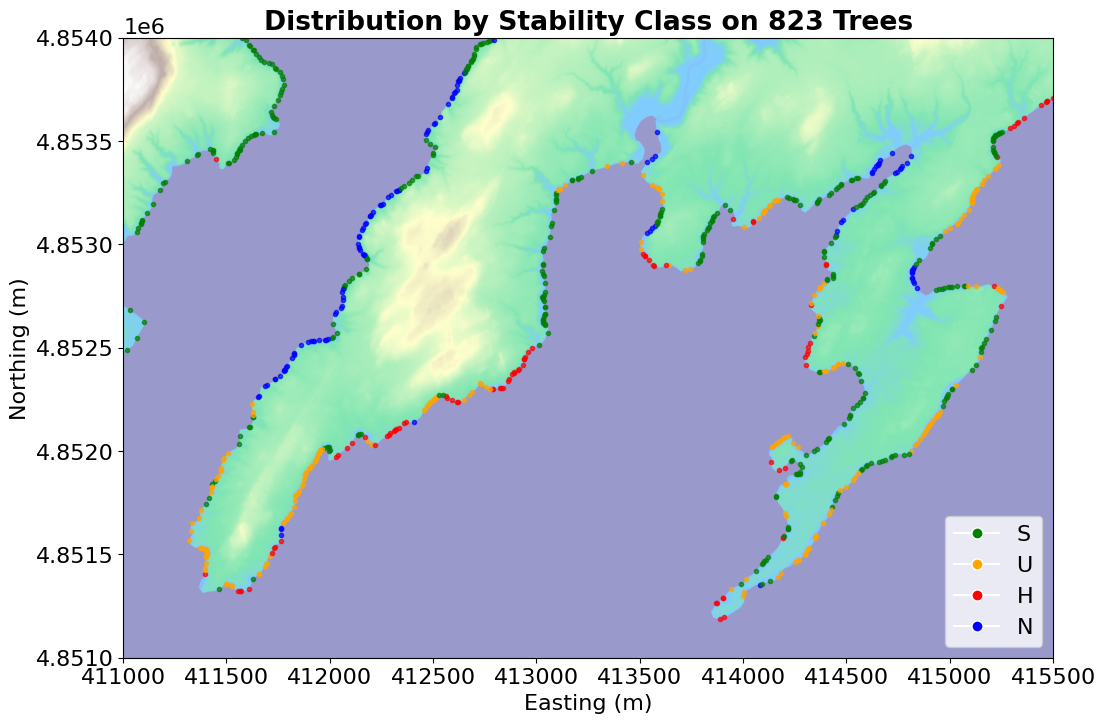

In [55]:
# 1.5.4 validate coastal pit locations and stability labels
# by plotting topographically and comparing to the digital map

plt.rcParams.update({'font.size': 16}) # Set the global font size to 16

labeled_pit_ids = list(labeled_trees.keys())
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(dem_data, cmap='terrain', alpha=0.5, extent=extent)

colors = {'S': 'green', 'U': 'orange', 'H': 'red', 'N': 'blue'}

for pit in labeled_pit_ids:
    r, c = wolfGraph.nodes[pit]['dem_idx']
    x, y = rasterio.transform.xy(transform, r, c)  # Convert to real coords
    stability = wolfGraph.nodes[pit]['stability']
    ax.plot(x, y, 'o', color=colors[stability], markersize=3, alpha=0.7)

ax.set_xlabel('Easting (m)')
ax.set_ylabel('Northing (m)')
plt.title(f"Distribution by Stability Class on {len(labeled_pit_ids)} Trees",fontweight='bold')
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', 
           markerfacecolor=c, label=s, markersize=8) 
           for s, c in colors.items()])
#plt.savefig("fig_823tree_stability.png")
plt.show()


In [28]:
# step 2 ## assign hydrodynamic properties ##

In [30]:
# 2.1 import selafin file
ds = xr.open_dataset('3DWolfsCoveApr20.slf', engine='selafin')

# note: IPOBO array..corrupted is a common warning
# print(ds) # optional verification
print(f"\nDimensions: {ds.dims}")
print(f"\nVariables: {list(ds.data_vars)}")
print(f"\nCoordinates: {list(ds.coords)}")
print(f"X range: {ds.x.min().values} to {ds.x.max().values}")
print(f"Y range: {ds.y.min().values} to {ds.y.max().values}")

The IPOBO array seems corrupted (zeros array). Try to rebuild it with `build_ipobo()`.



Dimensions: FrozenMappingWarningOnValuesAccess({'time': 4465, 'plan': 4, 'node': 10763})

Variables: ['Z', 'U', 'V', 'W', 'SALINITY']

Coordinates: ['x', 'y', 'time']
X range: 408782.8125 to 423926.59375
Y range: 4847213.5 to 4857609.5


In [31]:
# 2.2 retrieve and assign hydrodynamic data
# following Brown et al. retrieving from second layer (one after bottom)
# and using cubed velocity as a proxy for erosive power

# for (823) selected trees
selected_pit_ids = list(labeled_trees.keys())

# Get mesh coordinates
mesh_x = ds.x.values
mesh_y = ds.y.values
mesh_coords = np.column_stack([mesh_x, mesh_y])

# Build KD-tree for nearest neighbor
tree = cKDTree(mesh_coords)

# Extract velocities for your 823 labeled pits
pit_velocities = {}

for pit_idx in selected_pit_ids:
    # Get pit coordinates
    r, c = wolfGraph.nodes[pit_idx]['dem_idx']
    pit_x, pit_y = rasterio.transform.xy(transform, r, c)
    
    # Find nearest TELEMAC node
    dist, mesh_idx = tree.query([pit_x, pit_y])
    
    # Extract LAYER 1 (plan=1, ~1m above bed) velocities
    u_layer1 = ds.U.isel(node=mesh_idx, plan=1).values  # All timesteps
    v_layer1 = ds.V.isel(node=mesh_idx, plan=1).values
    
    # Calculate velocity magnitude
    vel_mag = np.sqrt(u_layer1**2 + v_layer1**2)
    
    # Erosive power (v³)
    erosive_power = vel_mag**3
    
    # Summary statistics
    max_vel = np.max(vel_mag)
    mean_vel = np.mean(vel_mag)
    std_vel = np.std(vel_mag)
    
    mean_erosive_power = np.mean(erosive_power)
    max_erosive_power = np.max(erosive_power)
    
    # Tidal range (from surface layer)
    z_surface = ds.Z.isel(node=mesh_idx, plan=-1).values
    tidal_range = np.max(z_surface) - np.min(z_surface)
    
    # Store
    pit_velocities[pit_idx] = {
        'max_vel': max_vel,
        'mean_vel': mean_vel,
        'std_vel': std_vel,
        'mean_erosive_power': mean_erosive_power,
        'max_erosive_power': max_erosive_power,
        'tidal_range': tidal_range,
        'distance_to_mesh': dist
    }
    
    # Add to graph
    wolfGraph.nodes[pit_idx]['max_vel'] = max_vel
    wolfGraph.nodes[pit_idx]['mean_vel'] = mean_vel
    wolfGraph.nodes[pit_idx]['std_vel'] = std_vel
    wolfGraph.nodes[pit_idx]['mean_erosive_power'] = mean_erosive_power
    wolfGraph.nodes[pit_idx]['max_erosive_power'] = max_erosive_power
    wolfGraph.nodes[pit_idx]['tidal_range'] = tidal_range

print("\nVelocity extraction complete!")
print(f"Processed {len(pit_velocities)} pits") # should match selected trees


Velocity extraction complete!
Processed 823 pits


In [32]:
# step 3 ## assign inflow attributes from edges ##

In [33]:
# 3.1 calculate and assign
selected_pit_ids = list(labeled_trees.keys())

# verify counts remain consistent
print(f"chosen: {len(selected_pit_ids)} pit ids")
print(f"chosen: {len(labeled_trees)} trees")

for pit_idx in selected_pit_ids:
    tree = labeled_trees[pit_idx]

    for node in tree.nodes():
        # Inflow edges (edges pointing TO this node)
        inflow_edges = list(tree.in_edges(node, data=True))
        
        if len(inflow_edges) > 0:
            inflow_slopes = [edge[2]['weight'] for edge in inflow_edges]
            
            total_inflow = sum(inflow_slopes)
            mean_inflow = np.mean(inflow_slopes)
            max_inflow = max(inflow_slopes)
        else:
            # Source node
            total_inflow = mean_inflow = max_inflow = 0
        
        # Add as node features
        tree.nodes[node]['total_inflow'] = total_inflow
        tree.nodes[node]['mean_inflow'] = mean_inflow  
        tree.nodes[node]['max_inflow'] = max_inflow

chosen: 823 pit ids
chosen: 823 trees


In [36]:
# 3.2 verify inflow assignment
# 1. Pick a random tree
test_pit = list(labeled_trees.keys())[800] # can adjust this index up to count-1
test_tree = labeled_trees[test_pit]

print(f"Testing tree {test_pit} with {test_tree.number_of_nodes()} nodes\n")

# 2. Check a few random nodes for new attributes
sample_nodes = list(test_tree.nodes())[:5]

for node in sample_nodes:
    attrs = test_tree.nodes[node]
    
    print(f"Node {node}:")
    print(f"  total_inflow: {attrs.get('total_inflow', 'MISSING')}")
    print(f"  mean_inflow: {attrs.get('mean_inflow', 'MISSING')}")
    print(f"  max_inflow: {attrs.get('max_inflow', 'MISSING')}")
    print(f"  in_degree: {test_tree.in_degree(node)}")  # Should match number of inflows
    print()

# 3. Check source nodes (should have 0 inflow)
source_nodes = [n for n in test_tree.nodes() if test_tree.nodes[n].get('is_source', False)]
if source_nodes:
    source = source_nodes[0]
    print(f"Source node {source}:")
    print(f"  total_inflow: {test_tree.nodes[source]['total_inflow']} (should be 0)")
    print(f"  in_degree: {test_tree.in_degree(source)} (should be 0)")
    print()

# 4. Check pit node (should have max inflows)
pit_node = test_pit
print(f"Pit node {pit_node}:")
print(f"  total_inflow: {test_tree.nodes[pit_node]['total_inflow']}")
print(f"  mean_inflow: {test_tree.nodes[pit_node]['mean_inflow']}")
print(f"  max_inflow: {test_tree.nodes[pit_node]['max_inflow']}")
print(f"  in_degree: {test_tree.in_degree(pit_node)}")
print()

# 5. Count how many nodes have the new attributes
nodes_with_inflow = sum(1 for n in test_tree.nodes() if 'total_inflow' in test_tree.nodes[n])
print(f"Nodes with inflow attributes: {nodes_with_inflow}/{test_tree.number_of_nodes()}")

Testing tree 749964 with 173 nodes

Node 785968:
  total_inflow: 0
  mean_inflow: 0
  max_inflow: 0
  in_degree: 0

Node 785969:
  total_inflow: 0.20086097717285156
  mean_inflow: 0.20086097717285156
  max_inflow: 0.20086097717285156
  in_degree: 1

Node 774717:
  total_inflow: 0.2188711166381836
  mean_inflow: 0.2188711166381836
  max_inflow: 0.2188711166381836
  in_degree: 1

Node 774718:
  total_inflow: 0
  mean_inflow: 0
  max_inflow: 0
  in_degree: 0

Node 774719:
  total_inflow: 0.23820589558865896
  mean_inflow: 0.23820589558865896
  max_inflow: 0.23820589558865896
  in_degree: 1

Pit node 749964:
  total_inflow: 29.993852510504016
  mean_inflow: 14.996926255252008
  max_inflow: 17.471298217773438
  in_degree: 2

Nodes with inflow attributes: 173/173


In [ ]:
# step 4 ## undersample and balance the dataset ##

In [38]:
# 4.1 version one: reduce Stable trees

# Keep all U and H
balanced_trees = {pit: tree for pit, tree in labeled_trees.items() 
                  if wolfGraph.nodes[pit]['stability'] in ['U', 'H']}

# Randomly sample 230 S trees
stable_pits = [pit for pit in labeled_trees.keys() 
               if wolfGraph.nodes[pit]['stability'] == 'S']
sampled_stable = random.sample(stable_pits, 230)

for pit in sampled_stable:
    balanced_trees[pit] = labeled_trees[pit]

print(f"Balanced dataset: {len(balanced_trees)} trees")

Balanced dataset: 550 trees


In [39]:
# 4.2 version two: keep only (balanced) Stable and Unstable trees
SU_trees = {pit: tree for pit, tree in balanced_trees.items() 
            if wolfGraph.nodes[pit]['stability'] in ['S', 'U']}

print(f"S vs U dataset: {len(SU_trees)} trees")

# Check distribution
su_labels = [wolfGraph.nodes[pit]['stability'] for pit in SU_trees.keys()]
print(pd.Series(su_labels).value_counts())

S vs U dataset: 459 trees
S    230
U    229
Name: count, dtype: int64


In [45]:
# step 5 ## SAVE ## (and don't rm -f !!)
# use git rm --cached file.pkl # instead! #

In [42]:
# 5.1 determine variables to save
save_dict = {
    'labeled_trees': labeled_trees,          # The 823 trees (-one nan stability)
    'SU_trees':SU_trees,                      # a 459 balanced SU dataset
    'wolfGraph': wolfGraph,                  # full graph with all attributes
    'label_map': {'S': 0, 'U': 1, 'H': 2, 'N': 3},  # For reference
    'transform': transform,                  # For coordinate conversions
    'dem_data': dem_data,                    # For plotting
    'extent': extent,                         # For spatial plots
    'bluffs': bluffs                         # for overlay plots   
}

In [43]:
with open('wolfGraphSU.pkl','wb') as f:
    pickle.dump(save_dict,f)
print("saved!")

saved!


In [44]:
# step 6 ## continue to neural networks! ##

In [46]:
## bonus steps: pretty plotting ##

In [49]:
with open('wolfGraphSU.pkl','rb') as q:
    dataq = pickle.load(q)
    labeled_trees = dataq['labeled_trees']
    SU_trees = dataq['SU_trees']
    wolfGraph = dataq['wolfGraph']
    transform = dataq['transform']
    extent = dataq['extent']
    dem_data = dataq['dem_data']
print("loaded!")

loaded!


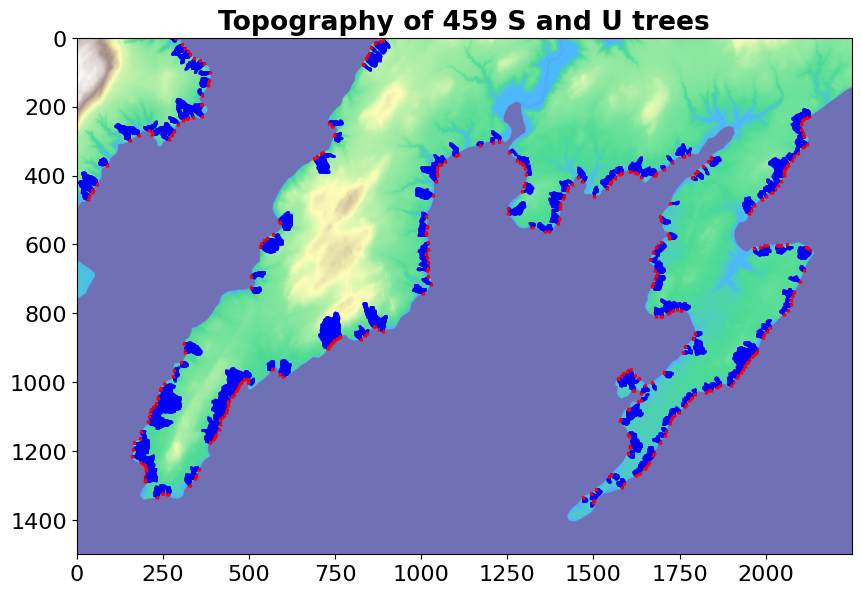

In [53]:
# plot all SU trees topographically (more would be pushing it)

plt.rcParams.update({'font.size': 16}) # Set the global font size to 16

selected_pit_ids = list(SU_trees.keys())

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(dem_data, cmap='terrain', alpha=0.7)


# Plot first 5 sources
for pit in selected_pit_ids:
    tree = labeled_trees[pit]
    

    #print(f"Tree nodes: {tree.number_of_nodes()}")
    #print(f"Tree edges: {tree.number_of_edges()}")
    
    
    for node in tree.nodes():
        r, c = tree.nodes[node]['dem_idx']
        ax.plot(c, r, 'bo', markersize=1, alpha=0.5)

    # Mark the pit
    pit_r, pit_c = tree.nodes[pit]['dem_idx']
    ax.plot(pit_c, pit_r, 'r^', markersize=2)
ax.set_title("Topography of 459 S and U trees",fontweight='bold')
#plt.savefig("fig_459SU_topography.png")
plt.show()

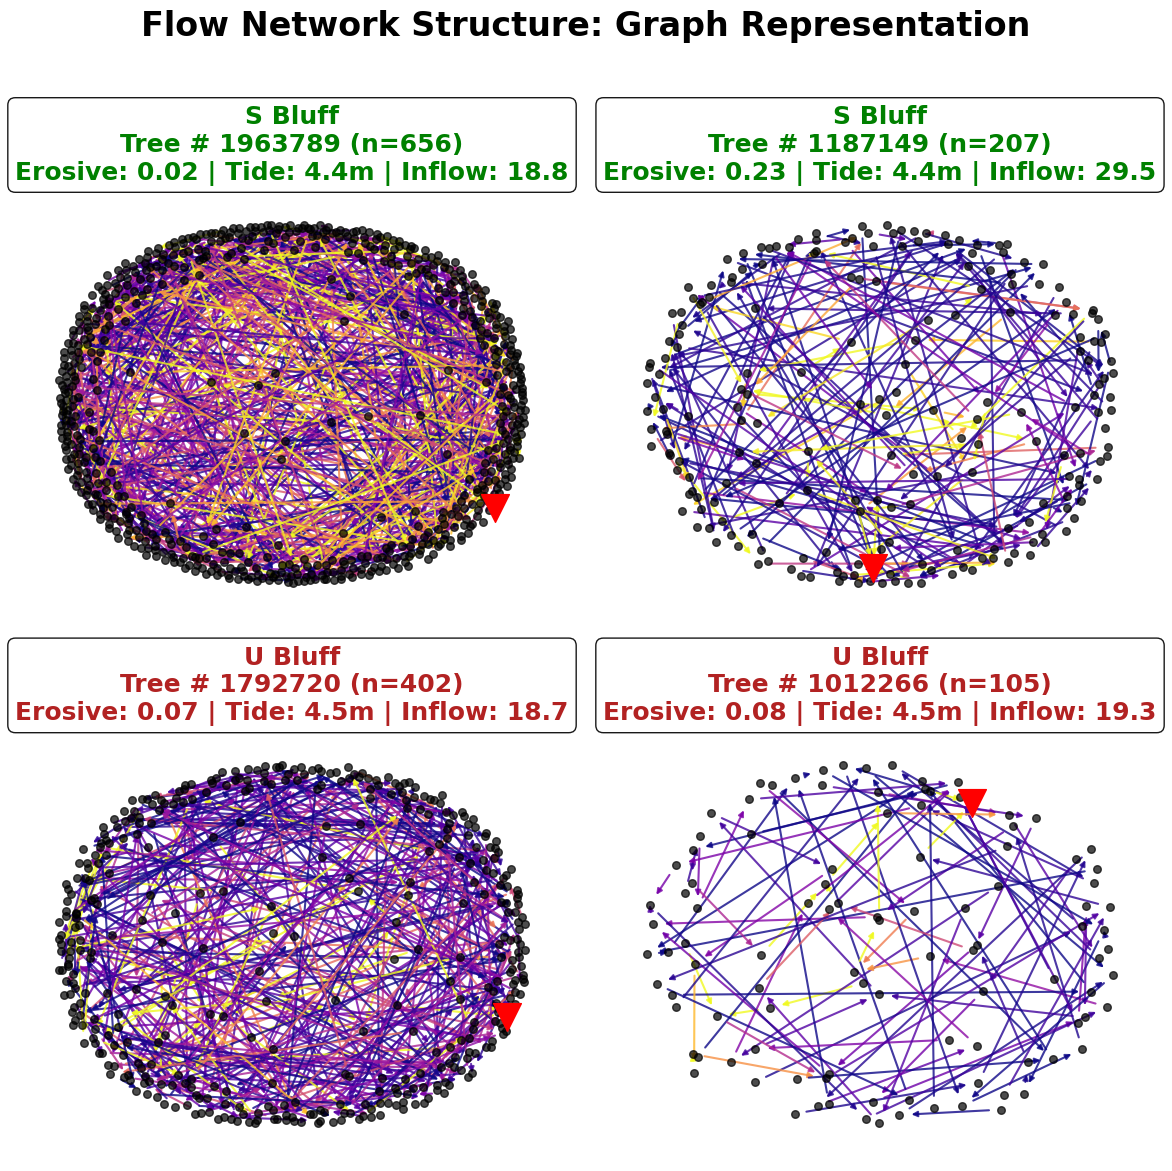

In [65]:
# visualize abstract trees
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

# Pick 2 stable, 2 unstable
stable_pits = [p for p in SU_trees.keys() if wolfGraph.nodes[p]['stability'] == 'S'][2:4][::-1] # flip order for asthetic purposes only
unstable_pits = [p for p in SU_trees.keys() if wolfGraph.nodes[p]['stability'] == 'U'][:2]
selected_pits = stable_pits + unstable_pits

for ax, pit_idx in zip(axes, selected_pits):
    tree = SU_trees[pit_idx]
    stability = wolfGraph.nodes[pit_idx]['stability']
    
    # Layout - try hierarchical for flow trees
    pos = nx.spring_layout(tree, k=0.5, iterations=50)
    # OR better for flow: nx.kamada_kawai_layout(tree)
    
    # Color edges by slope (weight)
    edge_weights = [tree.edges[e]['weight'] for e in tree.edges()]
    norm = Normalize(vmin=np.percentile(edge_weights, 10),  # Ignore lowest 10%
                 vmax=np.percentile(edge_weights, 90))  # And highest 10%
    
    # Draw
    nx.draw_networkx_nodes(tree, pos, ax=ax, 
                          node_color='k', 
                          node_size=30, alpha=0.7)
    
    nx.draw_networkx_edges(tree, pos, ax=ax,
                      edge_color=edge_weights,
                      edge_cmap=plt.cm.plasma,  # Try plasma or viridis
                      edge_vmin=norm.vmin,
                      edge_vmax=norm.vmax,
                      width=1.5, alpha=0.8,
                      arrows=True, arrowsize=8)
    
    # Highlight pit node
    # Pit = node with out_degree of 0
    pit_node = [n for n in tree.nodes() if tree.out_degree(n) == 0][0]
    # pit_pos = {pit_node: -pos[pit_node]}
    nx.draw_networkx_nodes(tree, pos, ax=ax, nodelist=[pit_node],
                          node_color='red', node_size=400, 
                          node_shape='v')
    
    # Get features
    max_eros = wolfGraph.nodes[pit_idx]['max_erosive_power']
    tidal = wolfGraph.nodes[pit_idx]['tidal_range']
    inflow = tree.nodes[pit_idx]['total_inflow']
    
    # Title with features
    color = 'green' if stability == 'S' else 'firebrick'
    ax.set_title(f"{stability} Bluff\nTree # {pit_node} (n={tree.number_of_nodes()})\nErosive: {max_eros:.2f} | Tide: {tidal:.1f}m | Inflow: {inflow:.1f}",
                fontsize=18, fontweight='bold', color=color,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.axis('off')

plt.suptitle('Flow Network Structure: Graph Representation\n ', 
            fontsize=24, fontweight='bold')
plt.tight_layout()
#plt.savefig('fig_4trees_abstract.png', dpi=300, bbox_inches='tight')
plt.show()

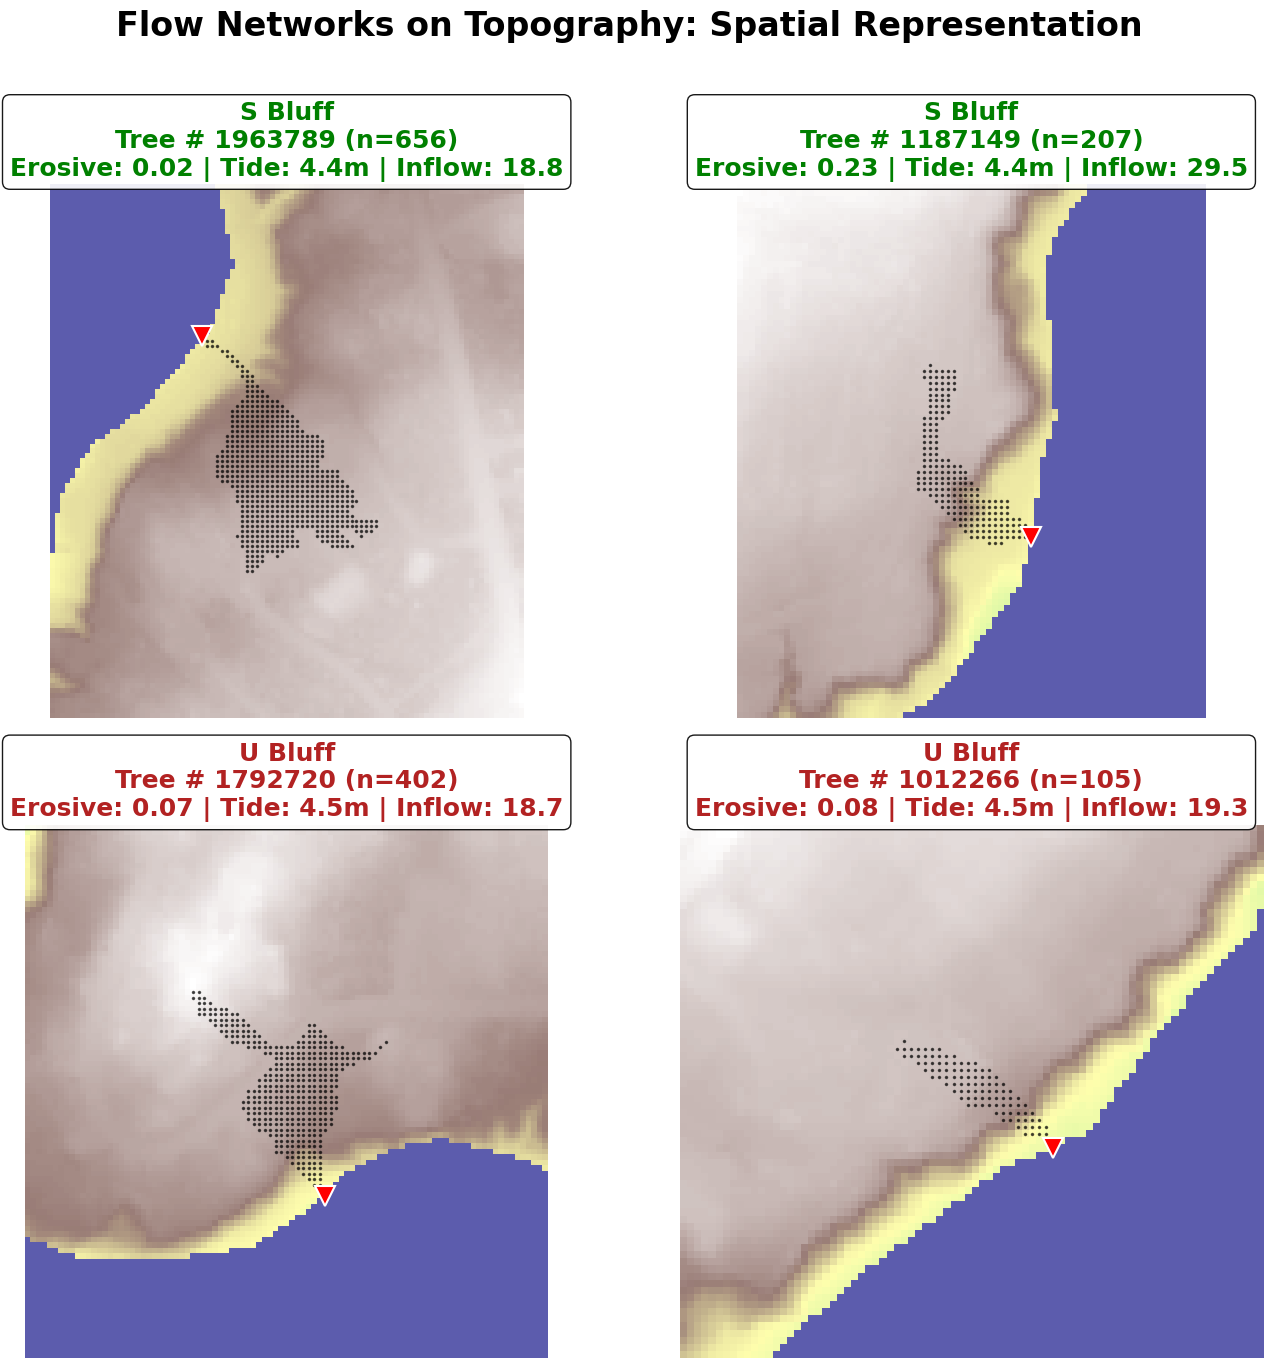

In [66]:
# visualize trees with topographic structure
fig, axes = plt.subplots(2, 2, figsize=(14, 14))
axes = axes.flatten()

# Use the SAME 4 pits as before
for ax, pit_idx in zip(axes, selected_pits):
    tree = SU_trees[pit_idx]
    stability = wolfGraph.nodes[pit_idx]['stability']
    
    # Get bounding box for tree
    tree_nodes = list(tree.nodes())
    rows = [wolfGraph.nodes[n]['dem_idx'][0] for n in tree_nodes]
    cols = [wolfGraph.nodes[n]['dem_idx'][1] for n in tree_nodes]
    
    # Add buffer around tree
    r_min, r_max = max(0, min(rows) - 30), min(dem_data.shape[0], max(rows) + 30)
    c_min, c_max = max(0, min(cols) - 30), min(dem_data.shape[1], max(cols) + 30)
    
    # Crop DEM
    dem_crop = dem_data[r_min:r_max, c_min:c_max]
    
    # Plot hillshade
    ax.imshow(dem_crop, cmap='terrain', alpha=0.8)
    
    # Plot tree nodes (small blue dots)
    for node in tree_nodes:
        r, c = wolfGraph.nodes[node]['dem_idx']
        r_local = r - r_min
        c_local = c - c_min
        ax.plot(c_local, r_local, 'o', color='k', markersize=1.5, alpha=0.6)
    
    # Find and highlight pit node
    pit_node = [n for n in tree.nodes() if tree.out_degree(n) == 0][0]
    pit_r, pit_c = wolfGraph.nodes[pit_node]['dem_idx']
    pit_r_local = pit_r - r_min
    pit_c_local = pit_c - c_min
    ax.plot(pit_c_local, pit_r_local, 'v', color='red', markersize=14, 
            markeredgecolor='white', markeredgewidth=1.5)
    
    # Get features
    max_eros = wolfGraph.nodes[pit_idx]['max_erosive_power']
    tidal = wolfGraph.nodes[pit_idx]['tidal_range']
    inflow = tree.nodes[pit_node]['total_inflow']
    
    # Title with features
    color = 'green' if stability == 'S' else 'firebrick'
    ax.set_title(f"{stability} Bluff\nTree # {pit_node} (n={tree.number_of_nodes()})\n" + 
                f"Erosive: {max_eros:.2f} | Tide: {tidal:.1f}m | Inflow: {inflow:.1f}",
                fontsize=18, fontweight='bold', color=color,
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))
    
    ax.axis('off')

plt.suptitle('Flow Networks on Topography: Spatial Representation\n ', 
            fontsize=24, fontweight='bold')
plt.tight_layout()
plt.savefig('fig_4trees_spatial.png', dpi=300, bbox_inches='tight')
plt.show()